In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")

In [3]:
def burrito_round1(day):
    m = gp.Model('burrito')
    csv_path = "csvs/round1/day"
    demand_node_df = pd.read_csv(csv_path+day+"/round1-day"+day+"_demand_node_data.csv")
    demand_node_df = demand_node_df.set_index('index')
    truck_node_df = pd.read_csv(csv_path+day+"/round1-day"+day+"_truck_node_data.csv")
    truck_node_df.set_index('index', inplace=True)
    demand_truck_df = pd.read_csv(csv_path+day+"/round1-day"+day+"_demand_truck_data.csv")
    demand_truck_df = demand_truck_df.set_index(['truck_node_index','demand_node_index'])
    scaled_demand = [demand_truck_df['scaled_demand']][0]
    problem_df = pd.read_csv(csv_path+day+"/round1-day"+day+"_problem_data.csv")
    burrito_price = problem_df['burrito_price'][0]
    ingredient_cost = problem_df['ingredient_cost'][0]
    truck_cost = problem_df['truck_cost'][0]
    profit = burrito_price-ingredient_cost
    print("Profit: ",profit)
    print("Truck Cost: ",truck_cost)
    customers = demand_node_df.index.values
    trucks = truck_node_df.index.values
    route_choice = m.addVars(
        trucks,customers,
        vtype = GRB.BINARY,
        name = "routes_assigned"
    )

    truck_choice = m.addVars(
        trucks,
        vtype = GRB.BINARY,
        name = "trucks_assigned"
    )
    route_con = m.addConstrs(
        (gp.quicksum(
            route_choice[i,j]
            for i in trucks
        ) <=1
        for j in customers),
        name = "route_constraint"
    )

    truck_con = m.addConstrs(
        (route_choice[i,j] <= truck_choice[i]
        for i in trucks for j in customers),
        name = "truck_constraint"
    )
    m.setObjective(
        gp.quicksum(
            profit * scaled_demand[i, j] * route_choice[i, j]
            for i in trucks
            for j in customers
        ) -
        gp.quicksum(
            truck_cost * truck_choice[i]
            for i in trucks
        ), GRB.MAXIMIZE
    )
    m.setParam('OutputFlag', 0)
    m.optimize()
    obj = m.getObjective().getValue()
    print("Max revenue: ", obj)
    route_solution = pd.Series(m.getAttr('X',route_choice), name='assigned_routes', index=demand_truck_df.index)
    sol = pd.concat([demand_truck_df, route_solution], axis=1)
    pos_sol = sol[sol['assigned_routes']>0]
    print(pos_sol)
    plt.figure(figsize=(10, 8))

    # Plot demand nodes in yellow
    plt.scatter(demand_node_df['x'], demand_node_df['y'], color='orange', label='Demand Nodes')

    # Plot truck nodes in blue
    plt.scatter(truck_node_df['x'], truck_node_df['y'], color='blue', label='Truck Nodes')

    assigned_trucks = pos_sol.index.get_level_values('truck_node_index').unique()
    assigned_trucks_df = truck_node_df.loc[assigned_trucks]
    plt.scatter(assigned_trucks_df['x'], assigned_trucks_df['y'], color='red', label='Assigned Trucks', edgecolor='black', s=70, marker='s')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Burrito Map')
    plt.legend()
    plt.grid(True)

    plt.gca().invert_yaxis()

    plt.show()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28
Profit:  5
Truck Cost:  250
Max revenue:  1190.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck14          demand0            207.250307              5              1.0
                 demand11           169.405417             29              1.0
                 demand12           168.175392             33              1.0
                 demand15           106.834879             19              1.0
                 demand16            82.384238             45              1.0
                 demand18           163.503716             31              1.0
                 demand19           138.520754             12              1.0
                 demand20           194.769637             24              1.0
truck56          demand22           168.867020             23         

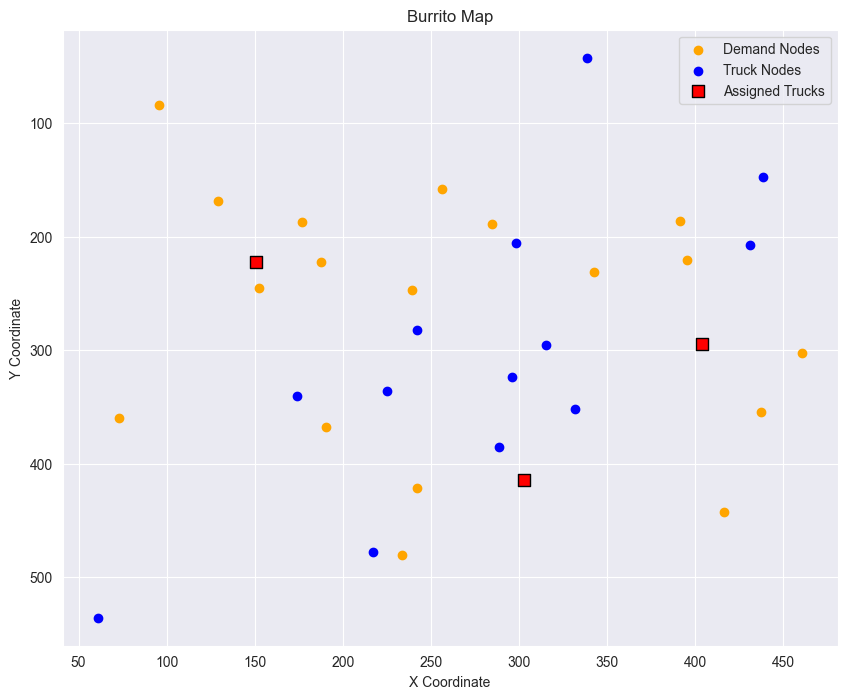

In [4]:
day = '1'
burrito_round1(day)

Profit:  5
Truck Cost:  250
Max revenue:  5355.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck7           demand0             84.969014             70              1.0
                 demand1             81.475266             65              1.0
                 demand2            161.831991             38              1.0
truck56          demand9            160.481660             28              1.0
truck53          demand11           149.687028             11              1.0
                 demand12           148.457003             53              1.0
truck7           demand15           128.845198             13              1.0
                 demand16           158.540911             32              1.0
truck53          demand17           182.601082             35              1.0
                 demand18            75.981013             10              1.0
   

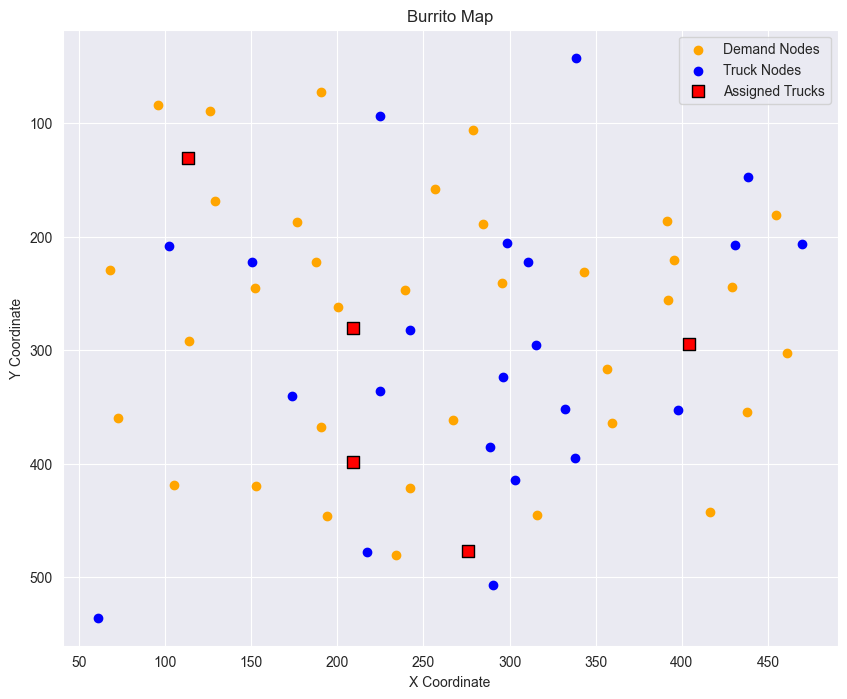

In [5]:
day = '2'
burrito_round1(day)

Profit:  3
Truck Cost:  250
Max revenue:  2594.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck7           demand0             84.969014             65              1.0
                 demand1             81.475266             65              1.0
                 demand2            161.831991             31              1.0
truck31          demand9            201.389450             20              1.0
truck52          demand11           149.262053             41              1.0
                 demand12           177.675490             24              1.0
truck7           demand15           128.845198             64              1.0
                 demand16           158.540911             28              1.0
truck52          demand17           211.819569             33              1.0
                 demand18           105.199500             39              1.0
   

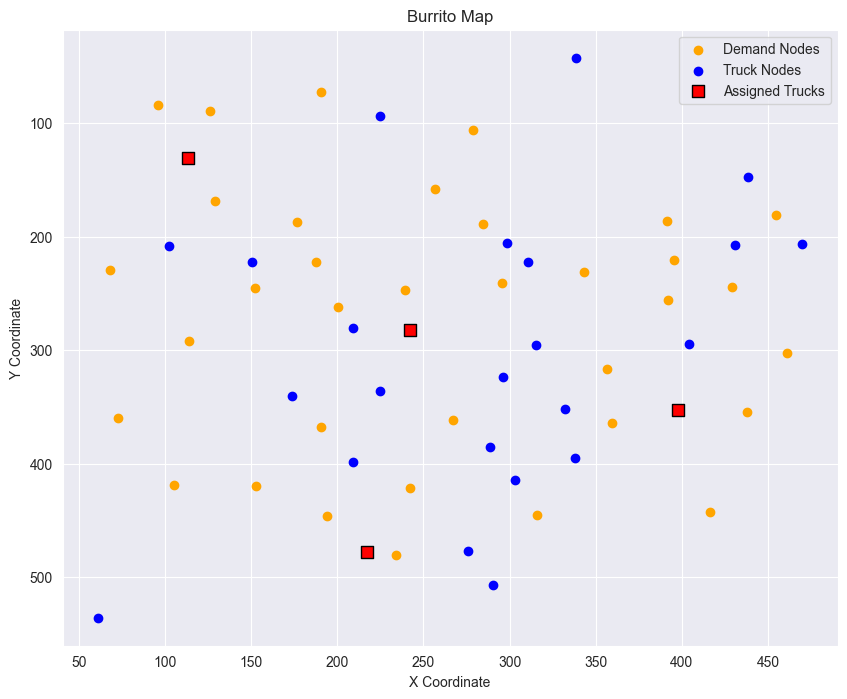

In [6]:
day = '3'
burrito_round1(day)

Profit:  5
Truck Cost:  250
Max revenue:  1660.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck7           demand0             84.969014             65              1.0
                 demand1             81.475266             29              1.0
truck12          demand2             74.733907             50              1.0
truck20          demand9             68.226943             10              1.0
truck14          demand15           106.834879             22              1.0
                 demand16            82.384238             53              1.0
                 demand17           139.459371              2              1.0
truck52          demand18           105.199500             45              1.0
                 demand19           115.673121              7              1.0
                 demand20            62.223425             15              1.0
   

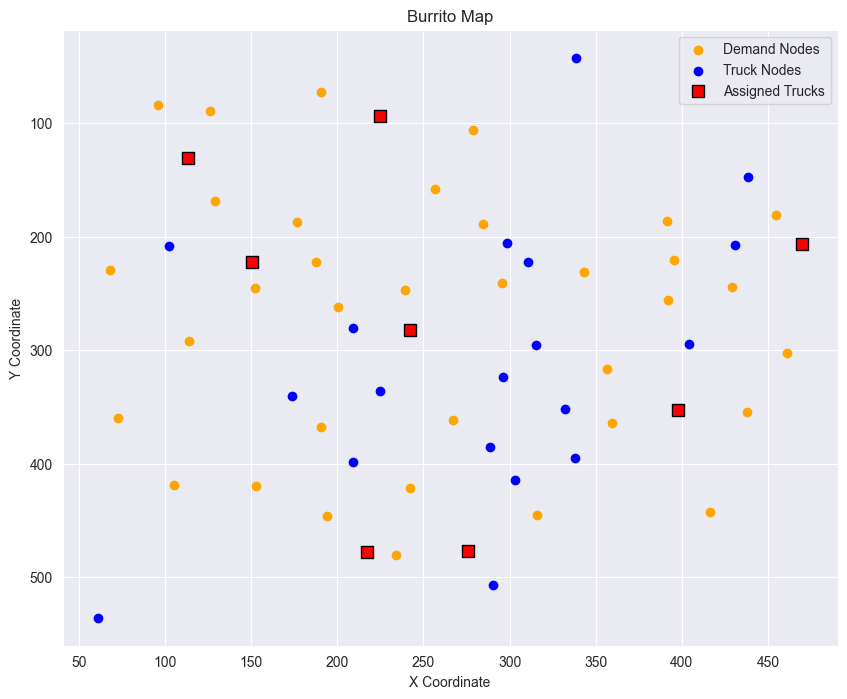

In [7]:
day = '4'
burrito_round1(day)

Profit:  5
Truck Cost:  250
Max revenue:  6745.0
                                      distance  scaled_demand  assigned_routes
truck_node_index demand_node_index                                            
truck8           demand0            136.315909             33              1.0
                 demand1            132.822161             25              1.0
                 demand2            113.778542             14              1.0
truck3           demand3            111.602182             42              1.0
                 demand4             60.935664             60              1.0
                 demand5            127.613252             56              1.0
truck21          demand6             92.973314             60              1.0
                 demand7            133.631535             21              1.0
truck3           demand8             93.999876             40              1.0
truck18          demand9            134.960058             54              1.0
tru

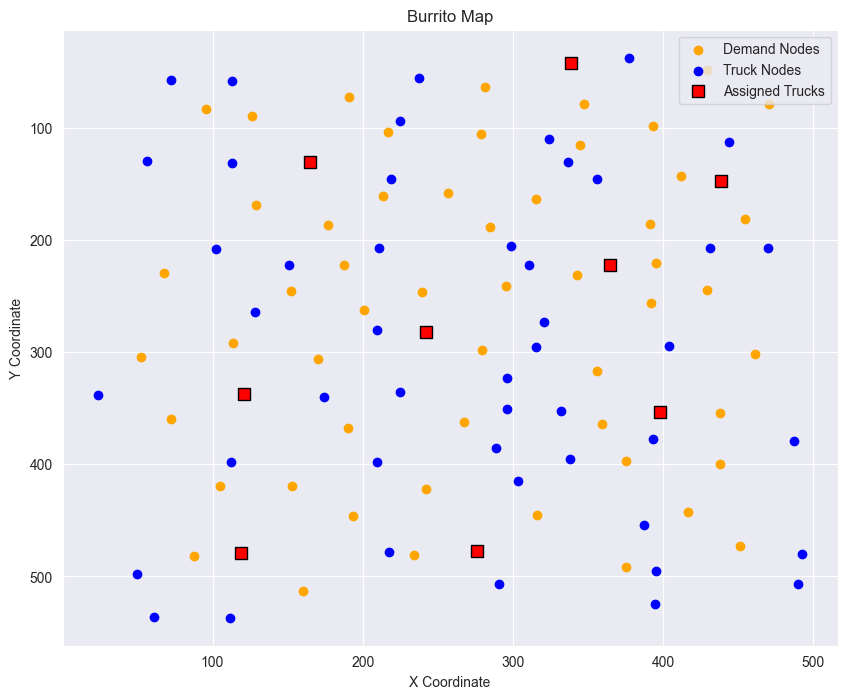

In [8]:
day = '5'
burrito_round1(day)